In [1]:
# ----------------------------
# 2. Image preprocessing
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return transform(img).unsqueeze(0)  # Add batch dim

# ----------------------------
# 3. Grad-CAM heatmap extraction
# ----------------------------
def get_gradcam_heatmap(model, img_tensor, target_class):
    img_tensor = img_tensor.to(device)
    
    # Hook for the last conv layer
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    last_conv = model.features[-1]
    last_conv.register_forward_hook(forward_hook)
    last_conv.register_backward_hook(backward_hook)

    # Forward pass
    outputs = model(img_tensor)
    if target_class is None:
        target_class = outputs.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    loss = outputs[0, target_class]
    loss.backward()

    # Compute Grad-CAM
    gradient = gradients[0].cpu().numpy()[0]
    activation = activations[0].cpu().numpy()[0]

    weights = gradient.mean(axis=(1,2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224,224))
    cam = cam - cam.min()
    cam = cam / cam.max()  # normalize 0-1
    return cam

# ----------------------------
# 4. Generate textual visual cues
# ----------------------------
def generate_visual_cues(cam, threshold=0.3):
    """
    cam: Grad-CAM heatmap normalized 0-1
    """
    # Convert to binary mask for high-importance regions
    mask = cam > threshold
    mask_area = mask.sum() / mask.size

    cues = []
    if mask_area > 0.02:  # >2% of image
        cues.append("brown spots")
    if mask.mean() > 0.2:
        cues.append("yellowing")
    if not cues:
        cues.append("no obvious disease spots")
    return ", ".join(cues)


NameError: name 'transforms' is not defined

Using device: cpu


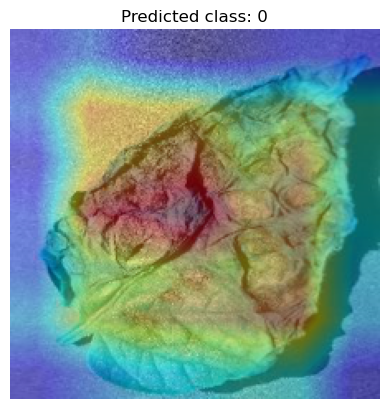

Predicted class: 0, Visual cues: brown spots, yellowing
Grad-CAM image saved successfully at: gradcam_result.jpg


In [5]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ----------------------------
# 1. Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 2. Load fine-tuned DenseNet121
# ----------------------------
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 3)  # 3 classes
model.load_state_dict(torch.load("best_densenet121_model.pth", map_location=device))
model.to(device)
model.eval()

# ----------------------------
# 3. Image preprocessing
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return transform(img).unsqueeze(0)  # Add batch dim

# ----------------------------
# 4. Grad-CAM extraction
# ----------------------------
def get_gradcam_heatmap(model, img_tensor, target_class=None):
    img_tensor = img_tensor.to(device)
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output.detach())
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Last convolutional layer
    last_conv = model.features[-1]
    last_conv.register_forward_hook(forward_hook)
    last_conv.register_backward_hook(backward_hook)

    outputs = model(img_tensor)
    if target_class is None:
        target_class = outputs.argmax(dim=1).item()

    model.zero_grad()
    loss = outputs[0, target_class]
    loss.backward()

    gradient = gradients[0].cpu().numpy()[0]
    activation = activations[0].cpu().numpy()[0]

    weights = gradient.mean(axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()  # normalize 0-1
    return cam

# ----------------------------
# 5. Generate textual visual cues
# ----------------------------
def generate_visual_cues(cam, threshold=0.3):
    mask = cam > threshold
    mask_area = mask.sum() / mask.size
    cues = []
    if mask_area > 0.02:
        cues.append("brown spots")
    if cam.mean() > 0.2:
        cues.append("yellowing")
    if not cues:
        cues.append("no obvious disease spots")
    return ", ".join(cues)

# ----------------------------
# 6. Load image and predict
# ----------------------------
img_path = r"C:\Users\Windows\Desktop\Recherche\aina2026\code\potatoData1\Potato___Early_blight\0e6b9e09-2bcd-41e0-b001-b80a33a8a78b___RS_Early.B 8694.jpg"
img_tensor = load_image(img_path)

with torch.no_grad():
    outputs = model(img_tensor.to(device))
    pred_class = outputs.argmax(dim=1).item()

# ----------------------------
# 7. Grad-CAM heatmap & overlay
# ----------------------------
heatmap = get_gradcam_heatmap(model, img_tensor, target_class=pred_class)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Convert PIL image to numpy array for overlay
img_np = np.array(Image.open(img_path).resize((224, 224)))
overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted class: {pred_class}")
plt.show()

# ----------------------------
# 8. Extract visual cues
# ----------------------------
visual_cues = generate_visual_cues(heatmap)
print(f"Predicted class: {pred_class}, Visual cues: {visual_cues}")
output_path = "gradcam_result.jpg"  # You can change the name or path
cv2.imwrite(output_path, overlay)

print(f"Grad-CAM image saved successfully at: {output_path}")


In [ ]:
#Step 2. Rule Extraction — Decision Tree from Meteorological Data
#Now we extract causal rules that explain how weather conditions relate to disease likelihood.
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text

# Load meteorological dataset
df = pd.read_csv("meteo_dataset.csv")
X = df.drop(["Disease", "Disease in number"], axis=1)
y = df["Disease in number"]

# Train Decision Tree
dtree = DecisionTreeClassifier(max_depth=4, random_state=42)
dtree.fit(X, y)

# Extract rules
rules = export_text(dtree, feature_names=list(X.columns))
print(rules)


In [ ]:
#Step 3. LLM Prompt Generation (for Explanation)
#Now we create a prompt template that combines both Grad-CAM insights and Decision Tree rules into a coherent explanation request.
def generate_explanation_prompt(leaf_class, weather_dict, rule_text, visual_desc):
    prompt = f"""
You are an agricultural assistant explaining a plant disease diagnosis.

Predicted class: {leaf_class}

Meteorological context:
{weather_dict}

Causal rules extracted from the decision tree:
{rule_text}

Visual cues from Grad-CAM:
{visual_desc}

Generate a short, clear explanation that links both the weather conditions and the visible symptoms observed on the leaf.
"""
    return prompt

# Example use:
weather_dict = {
    "Temperature": "19.8°C",
    "Humidity": "73%",
    "Wind Speed": "5.3 m/s",
    "Pressure": "1013 hPa"
}

visual_desc = "Leaf lesions are concentrated near the edges with dark discoloration zones."

rule_text = "If temperature < 22°C and humidity > 70%, the plant is likely affected by Early Blight."

prompt = generate_explanation_prompt("Early Blight", weather_dict, rule_text, visual_desc)
print(prompt)


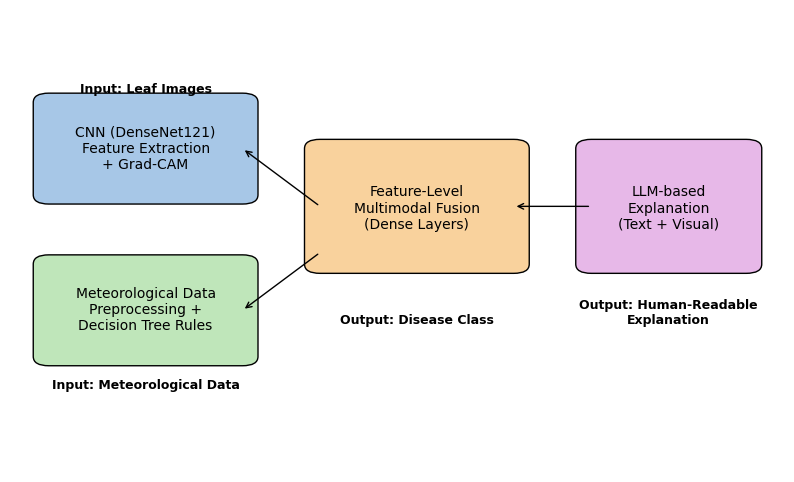

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# CNN block
cnn_box = mpatches.FancyBboxPatch((0.05, 0.6), 0.25, 0.2, boxstyle="round,pad=0.02", fc="#A7C7E7", ec="black")
ax.add_patch(cnn_box)
ax.text(0.175, 0.7, "CNN (DenseNet121)\nFeature Extraction\n+ Grad-CAM", ha='center', va='center', fontsize=10)

# Meteorological data block
meteo_box = mpatches.FancyBboxPatch((0.05, 0.25), 0.25, 0.2, boxstyle="round,pad=0.02", fc="#BFE6BA", ec="black")
ax.add_patch(meteo_box)
ax.text(0.175, 0.35, "Meteorological Data\nPreprocessing +\nDecision Tree Rules", ha='center', va='center', fontsize=10)

# Fusion block
fusion_box = mpatches.FancyBboxPatch((0.4, 0.45), 0.25, 0.25, boxstyle="round,pad=0.02", fc="#F9D29D", ec="black")
ax.add_patch(fusion_box)
ax.text(0.525, 0.57, "Feature-Level\nMultimodal Fusion\n(Dense Layers)", ha='center', va='center', fontsize=10)

# LLM Explanation block
llm_box = mpatches.FancyBboxPatch((0.75, 0.45), 0.2, 0.25, boxstyle="round,pad=0.02", fc="#E7B8E8", ec="black")
ax.add_patch(llm_box)
ax.text(0.85, 0.57, "LLM-based\nExplanation\n(Text + Visual)", ha='center', va='center', fontsize=10)

# Arrows
ax.annotate('', xy=(0.3, 0.7), xytext=(0.4, 0.575), arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('', xy=(0.3, 0.35), xytext=(0.4, 0.475), arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('', xy=(0.65, 0.575), xytext=(0.75, 0.575), arrowprops=dict(facecolor='black', arrowstyle='->'))

# Labels
ax.text(0.175, 0.82, "Input: Leaf Images", ha='center', fontsize=9, fontweight='bold')
ax.text(0.175, 0.18, "Input: Meteorological Data", ha='center', fontsize=9, fontweight='bold')
ax.text(0.525, 0.32, "Output: Disease Class", ha='center', fontsize=9, fontweight='bold')
ax.text(0.85, 0.32, "Output: Human-Readable\nExplanation", ha='center', fontsize=9, fontweight='bold')

plt.show()


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np

# ----------------------------
# 1. Load the CNN model (DenseNet121)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights="IMAGENET1K_V1")
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)  # 3 classes
model = model.to(device)
model.eval()

# ----------------------------
# 2. Image preprocessing
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return transform(img).unsqueeze(0)  # Add batch dim

# ----------------------------
# 3. Grad-CAM heatmap extraction
# ----------------------------
def get_gradcam_heatmap(model, img_tensor, target_class):
    img_tensor = img_tensor.to(device)
    
    # Hook for the last conv layer
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    last_conv = model.features[-1]
    last_conv.register_forward_hook(forward_hook)
    last_conv.register_backward_hook(backward_hook)

    # Forward pass
    outputs = model(img_tensor)
    if target_class is None:
        target_class = outputs.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    loss = outputs[0, target_class]
    loss.backward()

    # Compute Grad-CAM
    gradient = gradients[0].cpu().numpy()[0]
    activation = activations[0].cpu().numpy()[0]

    weights = gradient.mean(axis=(1,2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224,224))
    cam = cam - cam.min()
    cam = cam / cam.max()  # normalize 0-1
    return cam

# ----------------------------
# 4. Generate textual visual cues
# ----------------------------
def generate_visual_cues(cam, threshold=0.3):
    """
    cam: Grad-CAM heatmap normalized 0-1
    """
    # Convert to binary mask for high-importance regions
    mask = cam > threshold
    mask_area = mask.sum() / mask.size

    cues = []
    if mask_area > 0.02:  # >2% of image
        cues.append("brown spots")
    if mask.mean() > 0.2:
        cues.append("yellowing")
    if not cues:
        cues.append("no obvious disease spots")
    return ", ".join(cues)

# ----------------------------
# 5. Example usage
# ----------------------------
img_path = "leaf_example.jpg"
img_tensor = load_image(img_path)

# Predict class
with torch.no_grad():
    outputs = model(img_tensor.to(device))
    pred_class = outputs.argmax(dim=1).item()

# Get Grad-CAM
heatmap = get_gradcam_heatmap(model, img_tensor, target_class=pred_class)

# Generate visual cues
visual_cues = generate_visual_cues(heatmap)
print(f"Predicted class: {pred_class}, Visual cues: {visual_cues}")

# Output example:
# Predicted class: 1, Visual cues: brown spots, yellowing
